In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

mb_size = 32
X_dim = 784
z_dim = 20
h_dim = 128

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [4]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [5]:
X = tf.placeholder(tf.float32, shape=[None, X_dim])

D_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]


z = tf.placeholder(tf.float32, shape=[None, z_dim])

G_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

## WGAN

In [6]:
def sample_z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    out = tf.matmul(D_h1, D_W2) + D_b2
#     print(out)
    return out

In [7]:
G_sample = generator(z)
D_real = discriminator(X)
D_fake = discriminator(G_sample)

D_loss = tf.reduce_mean(D_real) - tf.reduce_mean(D_fake)
G_loss = -tf.reduce_mean(D_fake)

D_solver = (tf.train.RMSPropOptimizer(learning_rate=1e-4).minimize(-D_loss, var_list=theta_D))
G_solver = (tf.train.RMSPropOptimizer(learning_rate=1e-4).minimize(G_loss, var_list=theta_G))

clip_D = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in theta_D]

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

iterations = np.array([])
Dlist_loss = np.array([])
Glist_loss = np.array([])

for it in range(10000):
    for _ in range(5):
        X_mb, _ = mnist.train.next_batch(mb_size)

        _, D_loss_curr, _ = sess.run([D_solver, D_loss, clip_D],
                                     feed_dict={X: X_mb, z: sample_z(mb_size, z_dim)})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={z: sample_z(mb_size, z_dim)})

    if it % 100 == 0:
        iterations = np.append(iterations, it)
        Dlist_loss = np.append(Dlist_loss, D_loss_curr)
        Glist_loss = np.append(Glist_loss, G_loss_curr)
        
        print('Iter: {}; D loss: {:.4}; G_loss: {:.4}'
              .format(it, D_loss_curr, G_loss_curr))

        if it % 1000 == 0:
            samples = sess.run(G_sample, feed_dict={z: sample_z(16, z_dim)})

            fig = plot(samples)
            plt.savefig('out/{}.png'
                        .format(str(i).zfill(3)), bbox_inches='tight')
            i += 1
            plt.close(fig)

Iter: 0; D loss: 0.003861; G_loss: 0.0119
Iter: 100; D loss: 2.051; G_loss: 1.677
Iter: 200; D loss: 1.829; G_loss: 1.462
Iter: 300; D loss: 1.579; G_loss: 1.153
Iter: 400; D loss: 1.302; G_loss: 0.944
Iter: 500; D loss: 1.071; G_loss: 0.8801
Iter: 600; D loss: 0.7138; G_loss: 0.7521
Iter: 700; D loss: 0.4009; G_loss: 0.5607
Iter: 800; D loss: 0.2301; G_loss: 0.3433
Iter: 900; D loss: 0.1754; G_loss: 0.2245
Iter: 1000; D loss: 0.08578; G_loss: 0.08004
Iter: 1100; D loss: 0.04513; G_loss: -0.04706
Iter: 1200; D loss: 0.02092; G_loss: -0.02609
Iter: 1300; D loss: 0.006509; G_loss: -0.0206
Iter: 1400; D loss: 0.008937; G_loss: -0.0007242
Iter: 1500; D loss: 0.002964; G_loss: -0.04029
Iter: 1600; D loss: 0.0009704; G_loss: -0.057
Iter: 1700; D loss: 0.004772; G_loss: -0.05291
Iter: 1800; D loss: -0.002051; G_loss: -0.04357
Iter: 1900; D loss: 0.0007526; G_loss: -0.06915
Iter: 2000; D loss: 0.006248; G_loss: 0.08808
Iter: 2100; D loss: -0.001801; G_loss: 0.04746
Iter: 2200; D loss: -0.00396

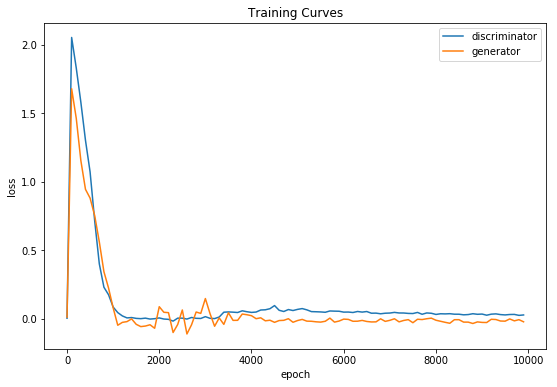

In [10]:
# summarize history for accuracy
plt.figure(figsize=(9, 6))
plt.plot(iterations, Dlist_loss)
plt.plot(iterations, Glist_loss)
plt.title('Training Curves')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['discriminator', 'generator'], loc='upper right')
plt.show()

## Improved WGAN

https://github.com/znxlwm/tensorflow-MNIST-GAN-DCGAN/blob/master/tensorflow_MNIST_DCGAN.py

In [11]:
def lrelu(x, th=0.2):
    return tf.maximum(th * x, x)

In [12]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(64, 64), cmap='Greys_r')

    return fig

In [13]:
def sample_z(m, n):
#     return np.random.uniform(-1., 1., size=[m, n])
     return np.random.normal(0, 1, (m, 1, 1, 100))


def generator(x, isTrain=True, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):

        # 1st hidden layer
        conv1 = tf.layers.conv2d_transpose(x, 1024, [4, 4], strides=(1, 1), padding='valid')
        lrelu1 = lrelu(tf.layers.batch_normalization(conv1, training=isTrain), 0.2)

        # 2nd hidden layer
        conv2 = tf.layers.conv2d_transpose(lrelu1, 512, [4, 4], strides=(2, 2), padding='same')
        lrelu2 = lrelu(tf.layers.batch_normalization(conv2, training=isTrain), 0.2)

        # 3rd hidden layer
        conv3 = tf.layers.conv2d_transpose(lrelu2, 256, [4, 4], strides=(2, 2), padding='same')
        lrelu3 = lrelu(tf.layers.batch_normalization(conv3, training=isTrain), 0.2)

        # 4th hidden layer
        conv4 = tf.layers.conv2d_transpose(lrelu3, 128, [4, 4], strides=(2, 2), padding='same')
        lrelu4 = lrelu(tf.layers.batch_normalization(conv4, training=isTrain), 0.2)

        # output layer
        conv5 = tf.layers.conv2d_transpose(lrelu4, 1, [4, 4], strides=(2, 2), padding='same')
        o = tf.nn.tanh(conv5)

        return o

# D(x)
def discriminator(x, isTrain=True, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # 1st hidden layer
        conv1 = tf.layers.conv2d(x, 128, [4, 4], strides=(2, 2), padding='same')
        lrelu1 = lrelu(conv1, 0.2)

        # 2nd hidden layer
        conv2 = tf.layers.conv2d(lrelu1, 256, [4, 4], strides=(2, 2), padding='same')
        lrelu2 = lrelu(tf.layers.batch_normalization(conv2, training=isTrain), 0.2)

        # 3rd hidden layer
        conv3 = tf.layers.conv2d(lrelu2, 512, [4, 4], strides=(2, 2), padding='same')
        lrelu3 = lrelu(tf.layers.batch_normalization(conv3, training=isTrain), 0.2)

        # 4th hidden layer
        conv4 = tf.layers.conv2d(lrelu3, 1024, [4, 4], strides=(2, 2), padding='same')
        lrelu4 = lrelu(tf.layers.batch_normalization(conv4, training=isTrain), 0.2)

        # output layer
        conv5 = tf.layers.conv2d(lrelu4, 1, [4, 4], strides=(1, 1), padding='valid')
        o = tf.nn.sigmoid(conv5)

        return o


In [14]:
# elif MODE == 'wgan-gp':

tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(None, 64, 64, 1))
z = tf.placeholder(tf.float32, shape=(None, 1, 1, 100))

G_sample = generator(z)
D_real = discriminator(X)
D_fake = discriminator(G_sample, reuse=True)

LAMBDA = 10 #Gradient penalty lambda hyperparameter
D_loss = tf.reduce_mean(D_real) - tf.reduce_mean(D_fake)
G_loss = -tf.reduce_mean(D_fake)

alpha = tf.random_uniform(
    shape=[mb_size,64, 64, 1], 
    minval=0.,
    maxval=1.)

differences = D_fake - D_real
print(differences.shape)
interpolates = D_real + (alpha*differences)
gradients = tf.gradients(discriminator(interpolates, reuse=True), [interpolates])[0]
slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
gradient_penalty = tf.reduce_mean((slopes-1.)**2)
D_loss += LAMBDA*gradient_penalty


T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('discriminator')]
G_vars = [var for var in T_vars if var.name.startswith('generator')]

G_solver = tf.train.AdamOptimizer(
    learning_rate=1e-4, 
    beta1=0.5,
    beta2=0.9
).minimize(G_loss, var_list=G_vars)

# D_solver = (tf.train.RMSPropOptimizer(learning_rate=1e-4)
#             .minimize(-D_loss, var_list=theta_D))

D_solver = tf.train.AdamOptimizer(
    learning_rate=1e-4, 
    beta1=0.5, 
    beta2=0.9
).minimize(D_loss, var_list=D_vars)

# clip_disc_weights = None

(?, 1, 1, 1)


In [15]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, reshape=[])

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [18]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out_improvedGAN_dgscan/'):
    os.makedirs('out_improvedGAN_dgscan/')

i = 0
iterations = np.array([])
Dlist_loss = np.array([])
Glist_loss = np.array([])

# MNIST resize and normalization
train_set = tf.image.resize_images(mnist.train.images, [64, 64]).eval(session=sess)
train_set = (train_set - 0.5) / 0.5  # normalization; range: -1 ~ 1
       
iterations = np.array([])
Dlist_loss = np.array([])
Glist_loss = np.array([])

for it in range(10000):
    for _ in range(5):
        
        X_mb = train_set[it*mb_size:(it+1)*mb_size]

        _, D_loss_curr = sess.run([D_solver, D_loss],
            feed_dict={X: X_mb, z: sample_z(mb_size, z_dim)})
    _, G_loss_curr = sess.run([G_solver, G_loss],feed_dict={z: sample_z(mb_size, z_dim)})

    if it % 100 == 0:
        iterations = np.append(iterations, it)
        Dlist_loss = np.append(Dlist_loss, D_loss_curr)
        Glist_loss = np.append(Glist_loss, G_loss_curr)
        
        print('Iter: {}; D loss: {:.4}; G_loss: {:.4}'
              .format(it, D_loss_curr, G_loss_curr))
        samples = sess.run(G_sample, feed_dict={z: sample_z(16, z_dim)})

        fig = plot(samples)
        plt.savefig('out_improvedGAN_dgscan/{}.png'
                    .format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)


Iter: 0; D loss: 8.556; G_loss: -0.6941


KeyboardInterrupt: 

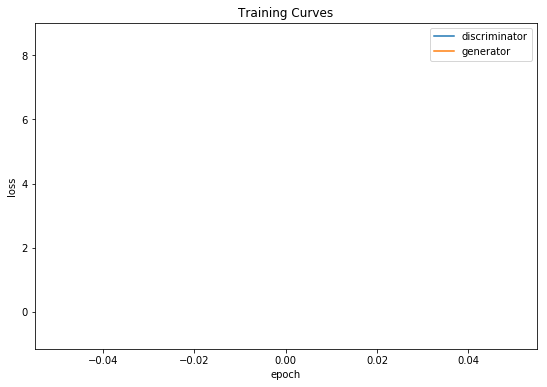

In [19]:
# summarize history for accuracy
plt.figure(figsize=(9, 6))
plt.plot(iterations, Dlist_loss)
plt.plot(iterations, Glist_loss)
plt.title('Training Curves')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['discriminator', 'generator'], loc='upper right')
plt.show()